<a href="https://colab.research.google.com/github/glukonatic/III/blob/master/III_PRO_01_BONUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus

Поставим исследовательскую задачу: определить для набора MNIST наиболее оптимальные способы построения и обучения модели.

In [0]:
#@title Загрузим необходимые библиотеки и определим глобальные переменные и функции
#@markdown Глобальные значения переменных (по умолчанию) defNeyronsInput (нейронов во входном слое) - 800, defHiddenLayers (число скрытых слоев) - 1, defNeyronsHidden (нейронов в скрытом слое/слоях) - 200, defBatchSize (пачка batch_size) - 128, defEpochs (число эпох) - 20, defVerbose (вывод хода обучения) - 0

defNeyronsInput = 800 #@param {type:"number"}
defHiddenLayers = 1 #@param {type:"number"}
defNeyronsHidden = 200 #@param {type:"number"}
defBatchSize = 128 #@param {type:"number"}
defEpochs = 20 #@param {type:"number"}
defVerbose = 0  #@param {type: "slider", min: 0, max: 1}

#@markdown ---


from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pylab as pl
import pandas as pd
import collections
import math
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
%matplotlib inline


defActivation = 'relu'

defMonitor = 'val_loss'
defMin_delta = 0
defPatience = 0
defMode = 'min'
defBaseline = None
defRestore_best_weights = False


# Переменная для реализации остановки обучения при достижении указанных параметров
earlyStopFit = EarlyStopping(
    monitor = defMonitor, # Отслеживаемый параметр (метрика).
    min_delta = defMin_delta, # минимальное изменение метрики, 
                                # которое можно считать за признак остановки, 
                                # то есть если абсолютное значение изменения больше этого параметра, 
                                # то происходит остановка
    patience = defPatience, # число эпох, пройденных при обучении, 
                                # на протяжении которых дельта не менялась. 
                                # При превышении этого числа - остановка
    verbose = defVerbose, # режим детализации
    mode = defMode, # одно из значений {auto, min, max}. 
                                # Если указано "min", обучение будет остановлено, 
                                # когда отслеживаемая метрика прекратит уменьшаться; 
                                # если указано "max", то обучение остановится 
                                # при прекращении увеличения отслеживаемой метрики; 
                                # при "auto" режиме обучение автоматически прекратится
                                # при прекращении изменения метрики.
    baseline = defBaseline, # опорное значение метрики. 
                                # Обучение будет остановлено, 
                                # если модель не покажет улучшение выше, чем этот параметр
    restore_best_weights = defRestore_best_weights # Следует ли восстанавливать веса модели, 
                                # вычисленные при достижении наилучшего показания метрики. 
                                # Если False, то модель будет иметь значения весов, 
                                # вычисленных на последнем шаге обучения
)


# Словари для сохранения истории экспериментов
historyNeyrons = collections.defaultdict()
historyBatchSize = collections.defaultdict()
historyActivation = collections.defaultdict()
customHistory = collections.defaultdict()

# Исходные данные датасета
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()

# Приведение данных датасета к необходимому виду
x_train = x_train_org.reshape(60000, 784)
x_test = x_test_org.reshape(10000, 784)
x_train = x_train.astype('float32')
x_train = x_train / 255
x_test = x_test.astype('float32')
x_test = x_test / 255
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)



# Определим глобальные функции для дальнейших экспериментов

# Функция для построения модели нейронной сети на основании заданных параметров
def createModel(numOfNeyronsInput=defNeyronsInput,numOfHiddenLayers=defHiddenLayers,
                numOfNeyronsHidden=defNeyronsHidden,activation=defActivation):
  '''
    Функция createModel, создающая модель с определенным количеством нейронов в скрытом слое.
    На вход принимает значения:
    numOfNeyronsInput - целочисленное значение, число нейронов во входном слое;
    numOfHiddenLayers - целочисленное значение, количество скрытых слоёв;
    numOfNeyronsHidden - целочисленное значение, число нейронов в скрытом слое;
    activation - тип активационной функции в скрытых слоях.
    По умолчанию функция принимает дефолтные значения аргументов.
    Функция возвращает созданную модель.
  '''
  model = Sequential()
  model.add(Dense(numOfNeyronsInput, input_dim=784, activation=activation))
  for i in range(numOfHiddenLayers):    
    model.add(Dense(numOfNeyronsHidden, activation=activation))
  model.add(Dense(10, activation="softmax"))
  return model



def fitModel(model, batchSize=defBatchSize, epochsNum=defEpochs, verboseBit=defVerbose):
  return model.fit(x_train, y_train, batch_size=batchSize,epochs=epochsNum, 
                   verbose=verboseBit, validation_split=0.1, callbacks=[earlyStopFit])



# Функция, рисующая графики на основании полученных данных в экспериментах
def runPlot(paramDict,experimentName):
  '''
    Функция runPlot, отрисовывающая графики по полученным в экспериментах данным
    На вход принимает значения:
    paramDict - словарь полученных в результате экспериментов данных
    experimentName - определяет, какой эксперимент был проведён
    Функция ничего не возвращает
  '''
  # Инициализируем графики, их у нас всегда по два - для точности и для потерь
  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25,10))
  f.suptitle('Графики для сравнения зависимости точности модели от выбранного параметра. Эксперимент: ' + experimentName)

  # Сформируем кастомные заголовки для графиков
  labels = []

  # Перебираем словарь результатов экспериментов
  for key, value in paramDict.items():
    labels.append(experimentName + ' = ' + str(key))
    ax1.plot(value.history['loss'])
    ax2.plot(value.history['accuracy'])

  # Разметим графики подписями осей, заголовками и легендой
  ax1.set_title('Потери моделей')
  ax1.set_ylabel('Потери')
  ax1.set_xlabel('Эпохи')
  ax1.grid(color='g', linestyle=':', linewidth=1)
  ax1.legend(labels, loc='upper right')
  ax2.set_title('Точность моделей')
  ax2.set_ylabel('Точность')
  ax2.set_xlabel('Эпохи')
  ax2.grid(color='g', linestyle=':', linewidth=1)
  ax2.legend(labels, loc='lower right')

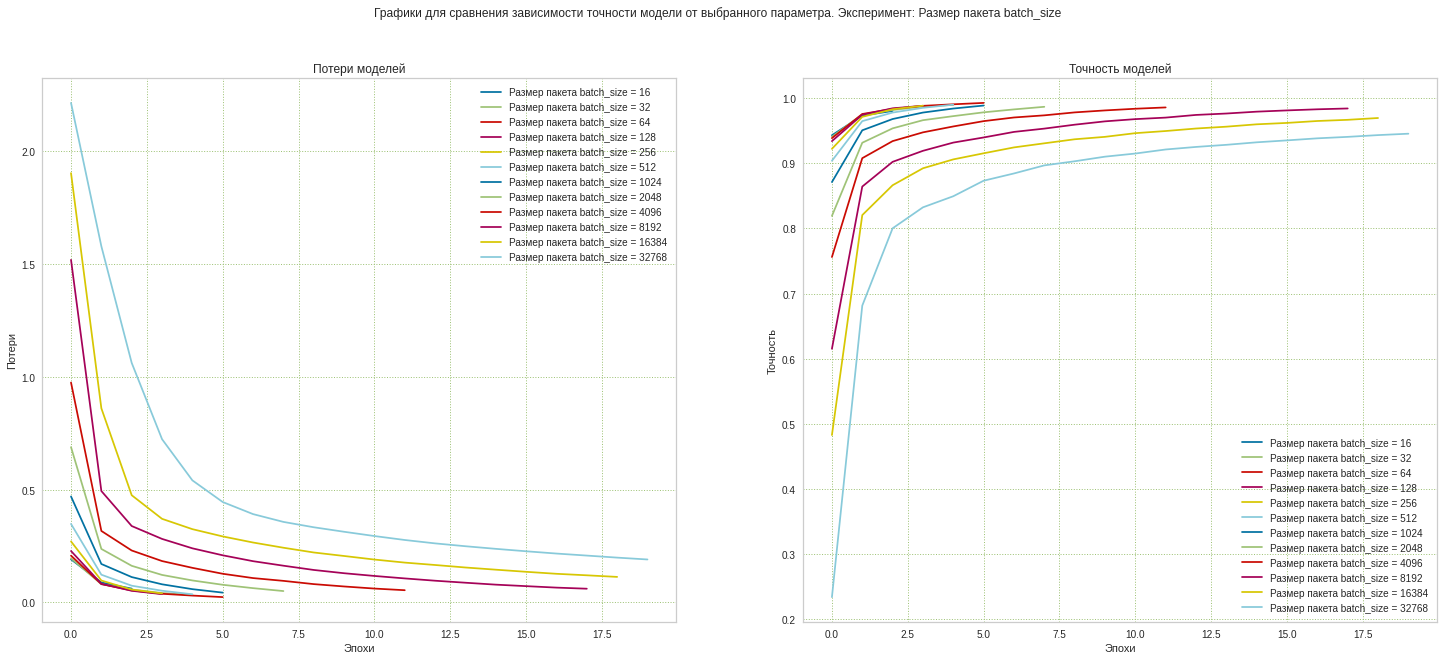

In [194]:
#@title Постановка эксперимента с изменением величины batch_size

customHistory.clear()
for customBatchSize in list(map(lambda x: 2**x, range(4,20))):
  if customBatchSize > 60000:
    break
  model = createModel()
  model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
  customHistory[customBatchSize] = fitModel(model, batchSize=customBatchSize)
runPlot(customHistory,'Размер пакета batch_size')

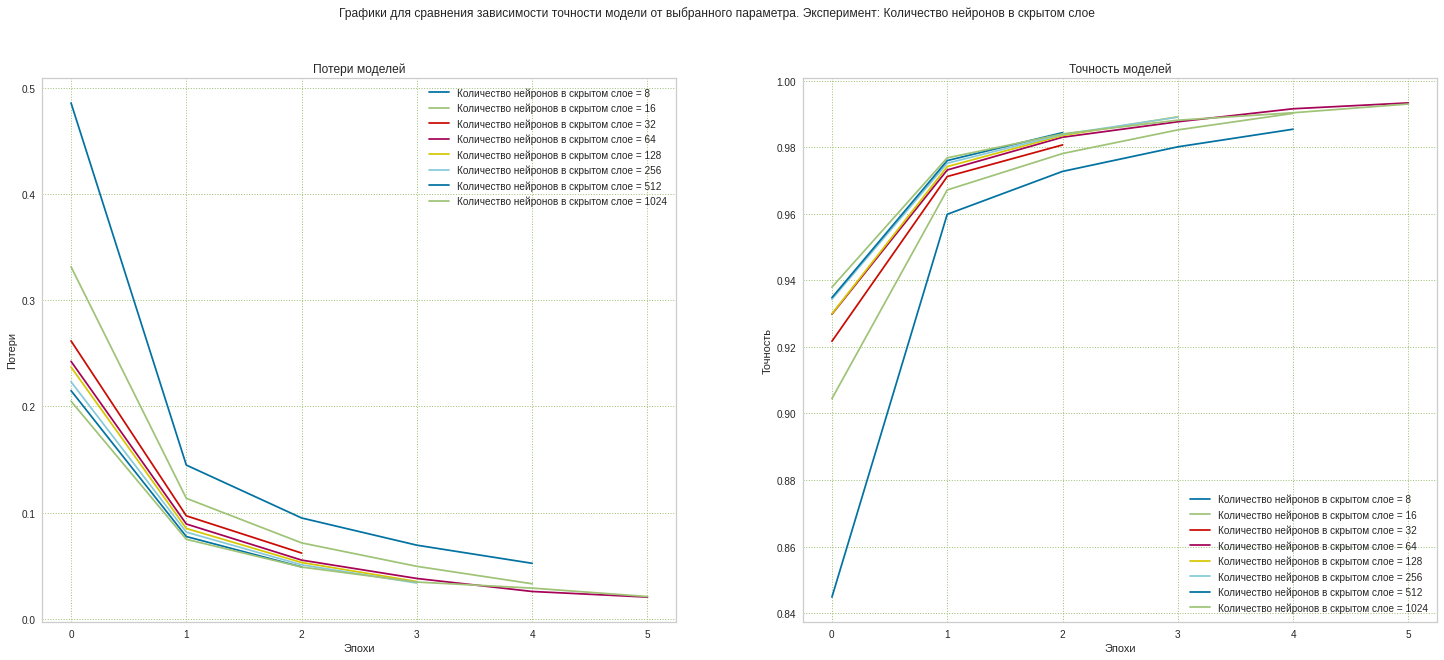

In [192]:
#@title Постановка эксперимента с изменением количества нейронов в одном скрытом слое

customHistory.clear()
for customNumOfNeyrons in list(map(lambda x: 2**x, range(3,11))):
  model = createModel(numOfNeyronsHidden=customNumOfNeyrons)
  model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
  customHistory[customNumOfNeyrons] = fitModel(model)
runPlot(customHistory,'Количество нейронов в скрытом слое')

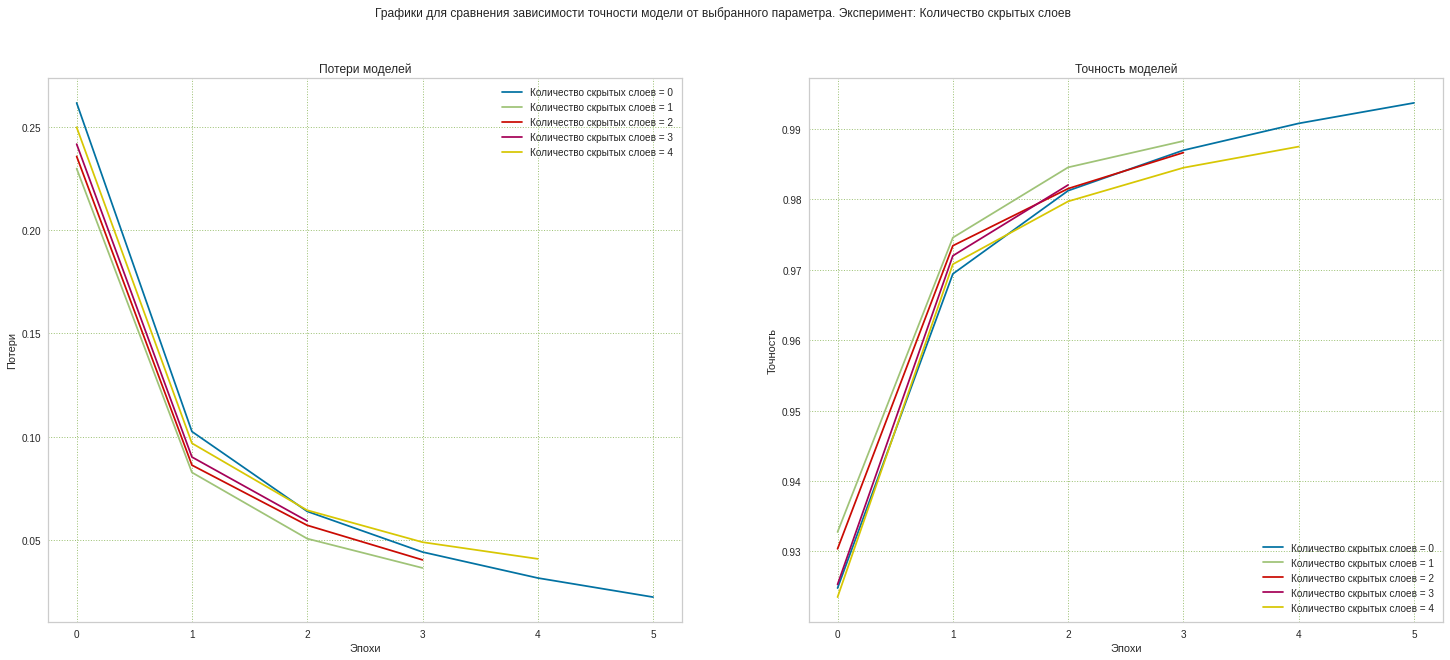

In [193]:
#@title Постановка эксперимента с изменением количества скрытых слоев

customHistory.clear()
for customNumOfHiddenLayers in range(0,5):
  model = createModel(numOfHiddenLayers=customNumOfHiddenLayers)
  model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
  customHistory[customNumOfHiddenLayers] = fitModel(model)
runPlot(customHistory,'Количество скрытых слоев')